# Neural Network Regularization Comparison

This project demonstrates the impact of different regularization techniques on training a neural network for a binary classification problem.  

We will compare:

1. **Base Model** (no regularization)  
2. **Dropout Regularization**  
3. **L2 Regularization (Weight Decay)**  
4. **L1 Regularization**  

We will train each model and plot the **training and validation loss** over epochs to observe how regularization affects generalization.


In [20]:
# =========================
# Libraries
# =========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


In [22]:
# =========================
# Data Loading & Preprocessing
# =========================
df = pd.read_csv("regularizer_lab_classification_dataset.csv")

# Features & target
x = df.drop(columns=['Target']).values
y = df['Target'].values

# Standardize features
scaler = StandardScaler()
x = scaler.fit_transform(x)

# Train-validation split
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

# Convert to tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
x_val_tensor = torch.tensor(x_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)

# DataLoaders
train_loader = DataLoader(TensorDataset(x_train_tensor, y_train_tensor), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(x_val_tensor, y_val_tensor), batch_size=32)


In [24]:
# =========================
# Neural Network Definition
# =========================
class BaseNN(nn.Module):
    def __init__(self, input_dim=x.shape[1], dropout_rate=0.0):
        super(BaseNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


In [30]:
def train_model(model, train_loader, val_loader, criterion, optimizer, l1_lambda=0.0, epochs=50):
    train_loss, val_loss = [], []

    for epoch in range(epochs):
        # Training
        model.train()
        running_loss = 0.0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            if l1_lambda > 0:
                l1_norm = sum(p.abs().sum() for p in model.parameters())
                loss += l1_lambda * l1_norm
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_loss_epoch = running_loss / len(train_loader)
        train_loss.append(train_loss_epoch)

        # Validation
        model.eval()
        with torch.no_grad():
            val_loss_epoch = sum(criterion(model(xb), yb).item() for xb, yb in val_loader) / len(val_loader)
        val_loss.append(val_loss_epoch)

        # Print losses
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss_epoch:.4f} | Validation Loss: {val_loss_epoch:.4f}")

    return train_loss, val_loss


In [32]:
# =========================
# Initialize Models & Optimizers
# =========================
base_model = BaseNN()
dropout_model = BaseNN(dropout_rate=0.5)
l2_model = BaseNN()
l1_model = BaseNN()

base_opt = optim.Adam(base_model.parameters(), lr=0.001)
dropout_opt = optim.Adam(dropout_model.parameters(), lr=0.001)
l2_opt = optim.Adam(l2_model.parameters(), lr=0.001, weight_decay=0.01)
l1_opt = optim.Adam(l1_model.parameters(), lr=0.001)

criterion = nn.BCELoss()


In [34]:
# =========================
# Train All Models
# =========================
print("Training base model...")
base_train, base_val = train_model(base_model, train_loader, val_loader, criterion, base_opt)

print("Training dropout model...")
dropout_train, dropout_val = train_model(dropout_model, train_loader, val_loader, criterion, dropout_opt)

print("Training L2-regularized model...")
l2_train, l2_val = train_model(l2_model, train_loader, val_loader, criterion, l2_opt)

print("Training L1-regularized model...")
l1_train, l1_val = train_model(l1_model, train_loader, val_loader, criterion, l1_opt, l1_lambda=0.001)


Training base model...
Epoch 1/50 | Train Loss: 0.6578 | Validation Loss: 0.6168
Epoch 2/50 | Train Loss: 0.5615 | Validation Loss: 0.5042
Epoch 3/50 | Train Loss: 0.4390 | Validation Loss: 0.3850
Epoch 4/50 | Train Loss: 0.3330 | Validation Loss: 0.3036
Epoch 5/50 | Train Loss: 0.2688 | Validation Loss: 0.2526
Epoch 6/50 | Train Loss: 0.2242 | Validation Loss: 0.2171
Epoch 7/50 | Train Loss: 0.1984 | Validation Loss: 0.1985
Epoch 8/50 | Train Loss: 0.1746 | Validation Loss: 0.1728
Epoch 9/50 | Train Loss: 0.1580 | Validation Loss: 0.1676
Epoch 10/50 | Train Loss: 0.1406 | Validation Loss: 0.1518
Epoch 11/50 | Train Loss: 0.1292 | Validation Loss: 0.1447
Epoch 12/50 | Train Loss: 0.1182 | Validation Loss: 0.1344
Epoch 13/50 | Train Loss: 0.1078 | Validation Loss: 0.1273
Epoch 14/50 | Train Loss: 0.0980 | Validation Loss: 0.1176
Epoch 15/50 | Train Loss: 0.0907 | Validation Loss: 0.1184
Epoch 16/50 | Train Loss: 0.0840 | Validation Loss: 0.1104
Epoch 17/50 | Train Loss: 0.0781 | Validat

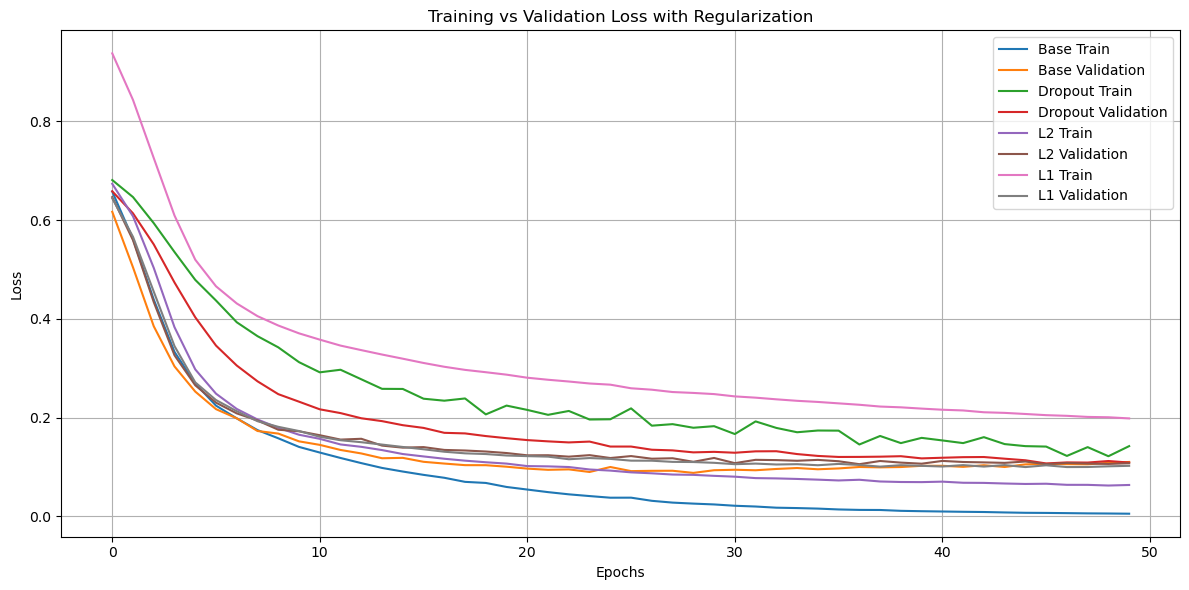

In [36]:
# =========================
# Plot Training vs Validation Loss
# =========================
plt.figure(figsize=(12, 6))
plt.plot(base_train, label='Base Train')
plt.plot(base_val, label='Base Validation')
plt.plot(dropout_train, label='Dropout Train')
plt.plot(dropout_val, label='Dropout Validation')
plt.plot(l2_train, label='L2 Train')
plt.plot(l2_val, label='L2 Validation')
plt.plot(l1_train, label='L1 Train')
plt.plot(l1_val, label='L1 Validation')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss with Regularization")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Project Summary: Regularization in Neural Networks

In this project, we explored the impact of different regularization techniques on a binary classification problem using PyTorch. 

**Models Trained:**
1. **Base Model** – Standard feedforward neural network without any regularization.
2. **Dropout Model** – Feedforward network with dropout layers to prevent overfitting.
3. **L2-Regularized Model** – Network trained with L2 weight decay.
4. **L1-Regularized Model** – Network trained with L1 regularization on weights.

**Observations from Training:**
- The **Base model** showed consistent reduction in training loss but validation loss started to plateau around epoch 30, indicating slight overfitting.
- The **Dropout model** had slower training loss reduction but maintained better generalization, as seen from the lower validation loss after 50 epochs.
- The **L2-regularized model** achieved a good balance between training and validation loss, indicating effective regularization.
- The **L1-regularized model** also reduced overfitting and promoted sparsity in the weights, though training loss was slightly higher initially.

**Conclusion:**
Regularization techniques such as Dropout, L1, and L2 help in reducing overfitting and improving generalization in neural networks. Choosing the appropriate regularization method can significantly impact the performance of the model on unseen data.
